# Jax likelihood

Where I try to implement the likelihood function in jax and compare it against existing runs before I try to do a full run for the KN inference.

In [1]:
# Basic imports
import numpy as np
import jax.numpy as jnp
import pandas as pd
import copy
import matplotlib.pyplot as plt
# matlotlib settings
params = {"axes.grid": True,
        "text.usetex" : False, # TODO enable latex, but this breaks if filters have underscore
        "font.family" : "serif",
        "ytick.color" : "black",
        "xtick.color" : "black",
        "axes.labelcolor" : "black",
        "axes.edgecolor" : "black",
        "font.serif" : ["Computer Modern Serif"],
        "xtick.labelsize": 16,
        "ytick.labelsize": 16,
        "axes.labelsize": 16,
        "legend.fontsize": 16,
        "legend.title_fontsize": 16,
        "figure.titlesize": 16}
plt.rcParams.update(params)

# NMMA imports
import nmma as nmma
from nmma.em.io import loadEvent

# flowMC imports
from flowMC.nfmodel.rqSpline import MaskedCouplingRQSpline
from flowMC.sampler.Gaussian_random_walk import GaussianRandomWalk
from flowMC.sampler.MALA import MALA
from flowMC.sampler.Sampler import Sampler
from flowMC.utils.PRNG_keys import initialize_rng_keys
from flowMC.nfmodel.utils import *

# jax imports
import jax
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_debug_nans", False)
import jaxlib
import jax.numpy as jnp
print("Checking if CUDA is found:")
print(jax.devices())

import utils
import json 

/home/urash/twouters/miniconda3/envs/nmma_gpu/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Checking if CUDA is found:
[cuda(id=0)]
Install afterglowpy if you want to simulate afterglows.
Install wrapt_timeout_decorator if you want timeout simulations.


/home/urash/twouters/miniconda3/envs/nmma_gpu/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/home/urash/twouters/nmma_models/flax_models/Bu2022Ye.pkl


2024-02-29 13:00:50.107100: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-29 13:00:50.107190: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-29 13:00:50.109155: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-29 13:00:51.864758: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/urash/twouters/nmma_gpu/nmma/em/model.py:293: UserWarning: Attempting to load Bu2022Ye_tf.pkl. In the future, all model files will have the format <model>.pkl, regardless of --interpolation-type.
  warnings.warn(


Loaded filter ps1__g
Loaded filter ps1__r
Loaded filter ps1__i
Loaded filter ps1__z
Loaded filter ps1__y
Loaded filter 2massj
Loaded filter 2massh
Loaded filter 2massks
Loaded filter sdssu


## Set up model and load data

Model parameters: taken from nmma/em/model.py

In [2]:
## Set-up model
# parameters = ['log10_mej_dyn', 'vej_dyn', 'Yedyn', 'log10_mej_wind', 'vej_wind', 'KNtheta']

parameters = ['log10_mej_dyn', 'vej_dyn', 'Yedyn', 'log10_mej_wind', 'vej_wind', 'inclination_EM']
prior_range = jnp.array([[-3, 1.7], [0.12, 0.25], [0.15, 0.3], [-2, 0.89], [-2, -0.89], [0, jnp.pi / 2]])
n_dim = len(prior_range)

# Load data
data_file = "../data/AT2017gfo_no_inf.dat"
trigger_time = 57982.5285236896
tmin, tmax = 0.05, 14
data = loadEvent(data_file)
filters = list(data.keys())
print("Filters: ", filters)
sample_times = jnp.linspace(tmin, tmax, 1_000)

Filters:  ['ps1__g', 'ps1__r', 'ps1__i', 'ps1__z', 'ps1__y', '2massj', '2massh', '2massks', 'sdssu']


## Posterior samples

In [3]:
# Load the posterior from a run by Peter
cpu_posterior_file = "../cpu_runs/Bu2022Ye_uniform_iota/outdir/AT2017gfo_Bu2022Ye_uniform_iota_result.json"
with open(cpu_posterior_file, "r") as f:
    cpu_posterior_json = json.load(f)
cpu_posterior = cpu_posterior_json["posterior"]["content"]
print(cpu_posterior.keys())

dict_keys(['inclination_EM', 'log10_mej_dyn', 'vej_dyn', 'Yedyn', 'log10_mej_wind', 'vej_wind', 'timeshift', 'luminosity_distance', 'Ebv', 'log_likelihood', 'log_prior'])


Load the samples and get the maximum likelihood sample

In [4]:
posterior_samples = np.array([cpu_posterior[param] for param in parameters])
posterior_samples = posterior_samples.T

log_likelihood_cpu = cpu_posterior["log_likelihood"]

# Get the maximum likelihood parameters
max_likelihood_idx = np.argmax(log_likelihood_cpu)
max_likelihood_params = posterior_samples[max_likelihood_idx]

print("max_likelihood_params")
for i, p in enumerate(parameters):
    print(f"{p}: {max_likelihood_params[i]}")

max_likelihood_params
log10_mej_dyn: -2.998431844478561
vej_dyn: 0.1298740818913512
Yedyn: 0.16264697303255118
log10_mej_wind: -1.347868718076242
vej_wind: 0.030187987224515975
inclination_EM: 0.004215726729039513


## Test LC generation

In [5]:
# Flax model
lc_max_likelihood_flax = utils.calc_lc_given_params_flax(max_likelihood_params, utils.sample_times)
lc_max_likelihood_flax_dict = {f: np.asarray(lc_max_likelihood_flax[f]) for f in utils.filters}

# Tensorflow model
lc_max_likelihood_tensorflow = utils.calc_lc_given_params_tensorflow(max_likelihood_params, utils.sample_times)
lc_max_likelihood_tensorflow_dict = {f: np.asarray(lc_max_likelihood_tensorflow[f]) for f in utils.filters}

Plot the 2 lightcurves as comparison

No handles with labels found to put in legend.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Serif


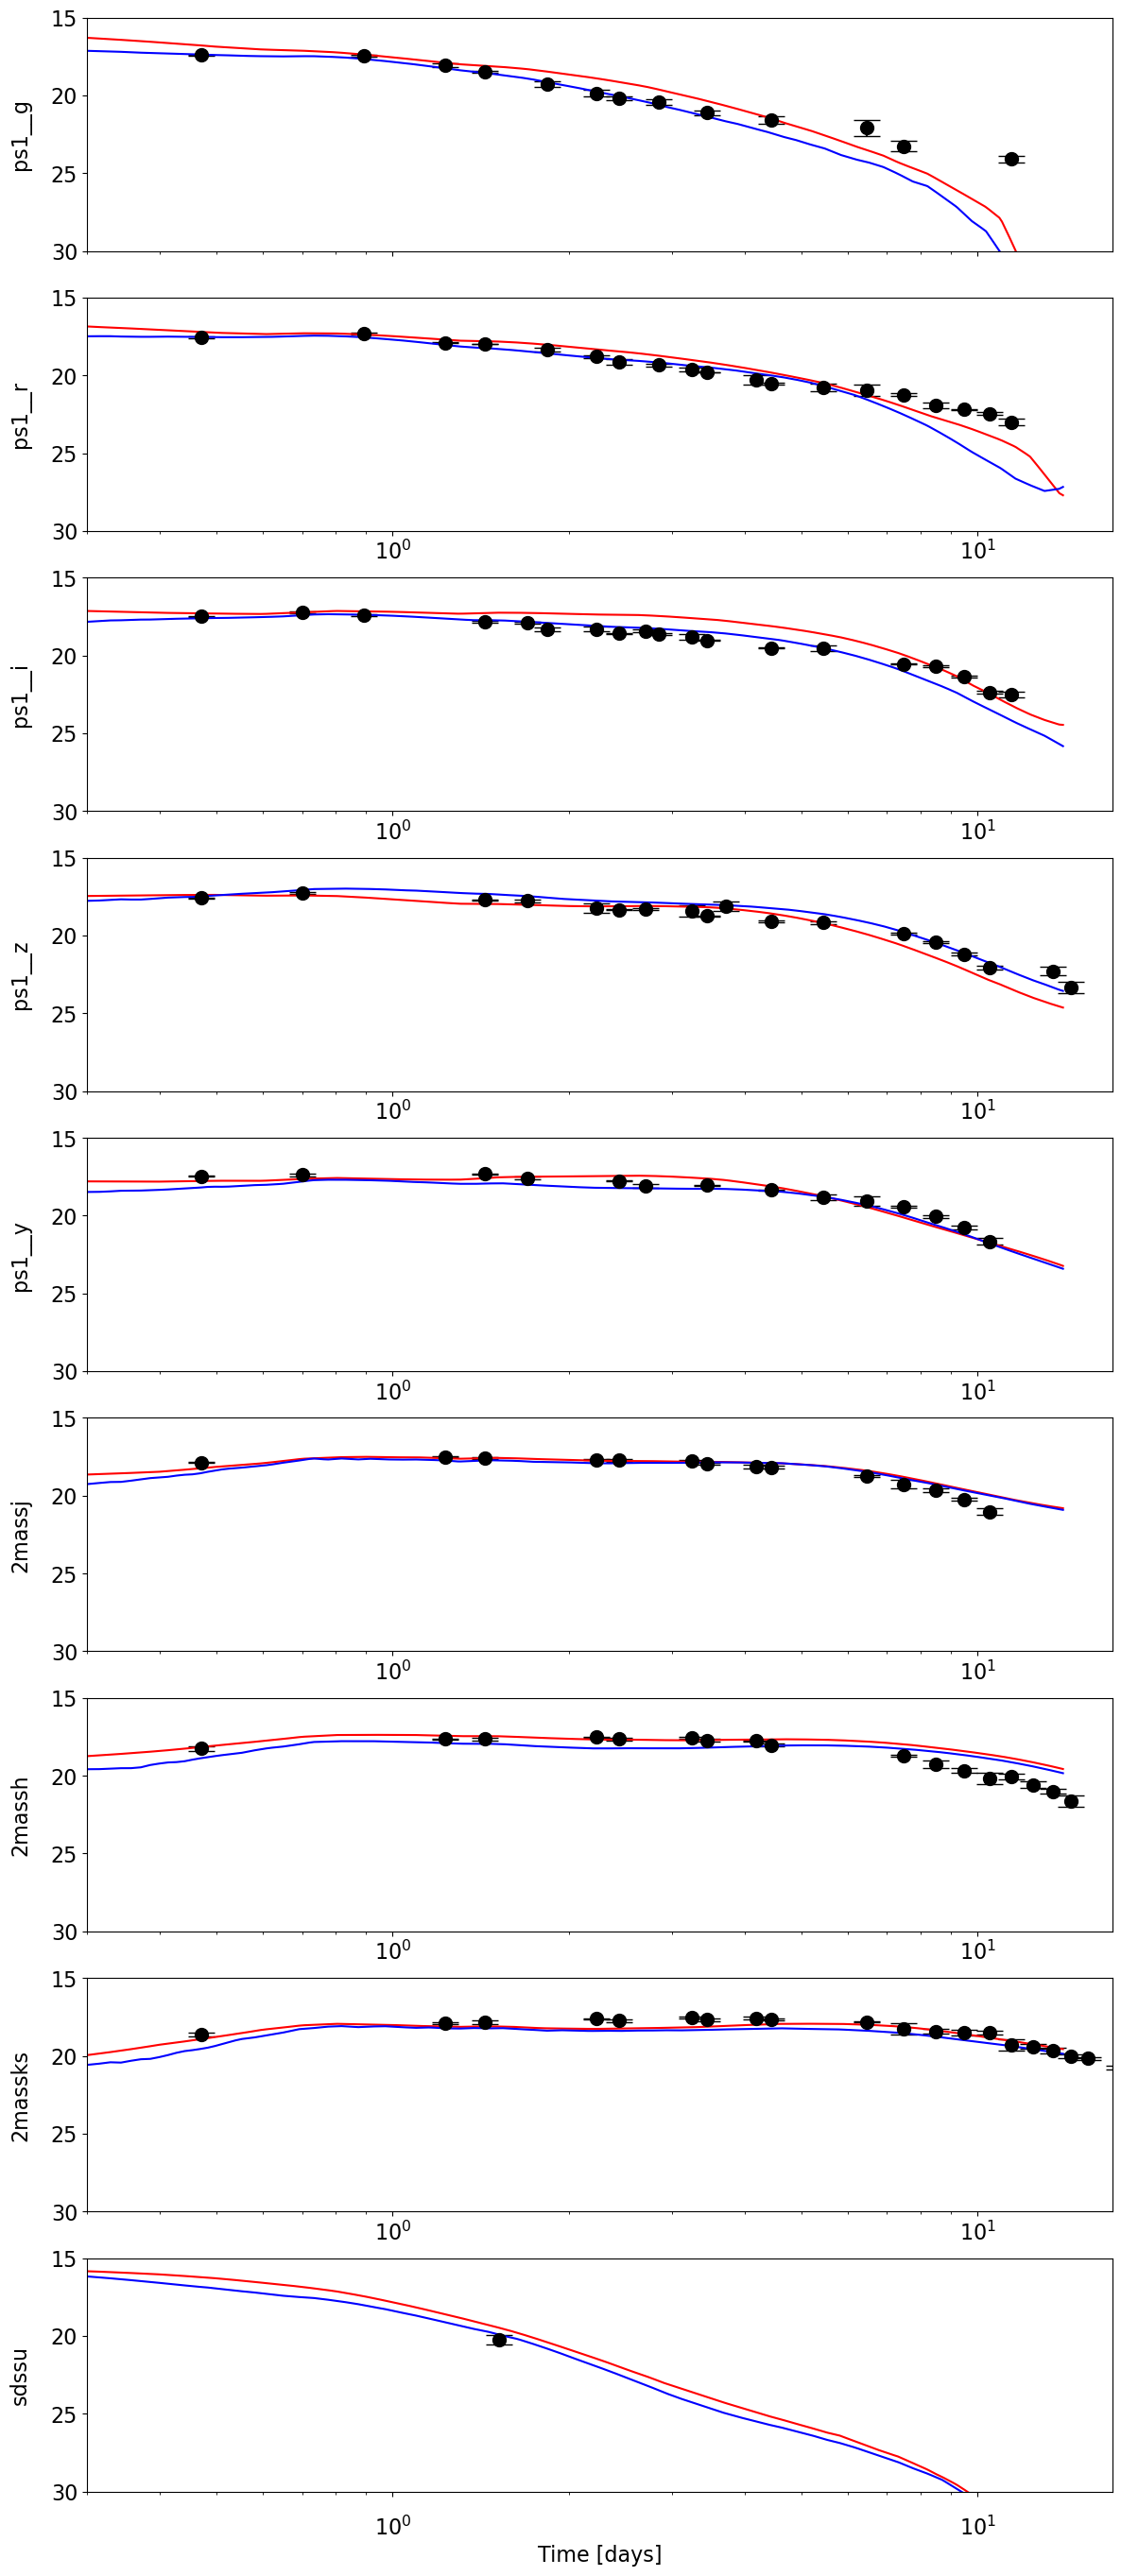

In [6]:
### Plot hyperparameters
set_ylim = True
set_yticks = True
show_legend = False
show_data = True

error_budget = '1.0'
error_budget = [float(x) for x in error_budget.split(",")]
error_budget = dict(zip(filters, error_budget * len(filters)))
xlim = f"{tmin},{tmax}"
ylim = "32, 15"
x_left = 3e-1
x_right = tmax + 3

# colors = cm.Spectral(np.linspace(0, 1, len(filters)))[::-1]

plt.figure(figsize=(14, 34))

cnt = 0
for filt in filters:
    cnt = cnt + 1
    if cnt == 1:
        ax1 = plt.subplot(len(filters), 1, cnt)
    elif cnt == 2 or cnt == 3:
        ax2 = plt.subplot(len(filters), 1, cnt, sharex=ax1)
    else:
        ax2 = plt.subplot(len(filters), 1, cnt, sharex=ax1)

    samples = data[filt]
    t, y, sigma_y = copy.deepcopy(samples[:, 0]), copy.deepcopy(samples[:, 1]), copy.deepcopy(samples[:, 2])
    t -= trigger_time   
    idx = np.where(~np.isnan(y))[0]
    t, y, sigma_y = t[idx], y[idx], sigma_y[idx]

    # 1) plot data points
    idx = np.where(np.isfinite(sigma_y))[0]
    plt.errorbar(t[idx], y[idx], sigma_y[idx], fmt="o", color='k', markersize=10, capsize=10)
    # plot upper bounds
    idx = np.where(~np.isfinite(sigma_y))[0]
    plt.errorbar(t[idx], y[idx], sigma_y[idx], fmt="v", color='k', markersize=10, capsize=10)

    # 2) plot tensorflow model
    my_mag = lc_max_likelihood_tensorflow[filt]
    plt.plot(utils.sample_times, my_mag, color="red")
    
    # 3) plot flax model
    my_mag = lc_max_likelihood_flax[filt]
    plt.plot(utils.sample_times, my_mag, color="blue")

    #plt.ylim([float(x) for x in ylim.split(",")])
    plt.xlim([float(x) for x in xlim.split(",")])
    plt.xscale('log')
    plt.grid()
    
    filt_label = filt
    
    if cnt == 1:
        
        plt.ylabel(filt_label, rotation=90, labelpad=15)
        if set_ylim:
            ax1.set_ylim([30,15])
        #plt.ylim([float(x) for x in ylim.split(",")])
    else:
        # filt_label = filt.replace("__", "-")
        plt.ylabel(filt_label, rotation=90, labelpad=15)
        if set_ylim:
            ax2.set_ylim([30,15])
        #plt.ylim([float(x) for x in ylim.split(",")])

    if cnt == 1:
        if set_yticks:
            ax1.set_yticks([30, 25, 20, 15])
        else:
            ax1.invert_yaxis()
        ax1.set_xlim(left=x_left, right=x_right)
        plt.setp(ax1.get_xticklabels(), visible=False)
        legend = plt.legend(loc = "center", bbox_to_anchor=(0.5, 1.2), shadow=False,
                            fancybox=True, ncol=4)
        legend.get_frame().set_alpha(None)
    else:
        if set_yticks:
            ax2.set_yticks([30, 25, 20, 15])
        else:
            ax2.invert_yaxis()
        ax2.set_xlim(left=x_left, right=x_right)
    

ax1.set_zorder(1)
plt.xlabel("Time [days]")
ax2.tick_params(axis='x', which='major', pad=15)
#plt.legend(bbox_to_anchor=(0., 12.9, 1.025, .0), ncol=2, fontsize=40, frameon=True)
#plt.tight_layout()
plt.subplots_adjust(hspace=0.2, wspace=0)

if not show_legend:
    legend.remove()

if show_data:
    plt.show()
else:
    plt.close()

### Time comparison LC generation

#### Tensorflow model

In [14]:
def my_fn_original():
    # Sample parameters from the prior range
    params = np.random.uniform(prior_range[:, 0], prior_range[:, 1])
    lc = utils.calc_lc_given_params_tensorflow(params, utils.sample_times)
    return lc

In [15]:
%timeit my_fn_original()

348 ms ± 15.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### Flax model

In [17]:
calc_lc_given_params_flax_jit = jax.jit(utils.calc_lc_given_params_flax)
# Call once to do compilation
_ = calc_lc_given_params_flax_jit(max_likelihood_params, utils.sample_times)

In [31]:
def my_fn_flax():
    # Sample parameters from the prior range
    params = np.random.uniform(prior_range[:, 0], prior_range[:, 1])
    lc = calc_lc_given_params_flax_jit(params, utils.sample_times)
    return lc

In [32]:
# Call once to make sure is compiled
_ = my_fn_flax()

In [30]:
%timeit my_fn_flax()

1.34 ms ± 127 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


Work in progress: check vmap

In [ ]:
# params = np.random.uniform(prior_range[:, 0], prior_range[:, 1], size = (1000, n_dim))
# calc_lc_vmap = jax.vmap(utils.calc_lc_given_params_jit)
# # Sample parameters from the prior range
# params = np.random.uniform(prior_range[:, 0], prior_range[:, 1], size = (1000, n_dim))
# params = jnp.array(params)
# def my_fn_flax_vmap():
#     _, _, lc = calc_lc_vmap(params)
#     return lc

In [ ]:
# %timeit -n 1 my_fn_flax_vmap()

1.95 ms ± 433 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Likelihood

TODO
- do we need to apply data process? (from utils)
- 

Priors:  at `/home/urash/twouters/gpu_projects/KN_inference/cpu/priors/AT2017gfo_Bu2022Ye_uniform_iota.prior`:

In [33]:
# Make data a jnp array
for filt in utils.filters:
    utils.data[filt] = jnp.asarray(utils.data[filt])

Focus on the first filter

In [34]:
filt = utils.filters[0]
data_times = copy.deepcopy(utils.data[filt][:, 0])
data_times_shifted = data_times - utils.trigger_time
data_mag = copy.deepcopy(utils.data[filt][:, 1])
data_sigma = copy.deepcopy(utils.data[filt][:, 2])
error_budget = 1.0
detection_limit = 99999.0
data_sigma = jnp.sqrt(data_sigma ** 2 + error_budget ** 2)

# dummy estimated magnitudes
mag_est = data_mag + 0.1

In [35]:
print("data_times")
print(data_times)
print("data_times_shifted")
print(data_times_shifted)
print("data_mag")
print(data_mag)
print("data_sigma")
print(data_sigma)

data_times
[57983.    57983.42  57983.758 57983.969 57984.37  57984.761 57984.969
 57985.38  57985.974 57986.974 57988.99  57990.    57993.94 ]
data_times_shifted
[ 0.47147631  0.89147631  1.22947631  1.44047631  1.84147631  2.23247631
  2.44047631  2.85147631  3.44547631  4.44547631  6.46147631  7.47147631
 11.41147631]
data_mag
[17.41 17.46 18.05 18.49 19.28 19.87 20.19 20.43 21.13 21.58 22.08 23.28
 24.1 ]
data_sigma
[1.00019998 1.0031949  1.00717426 1.00079968 1.01434708 1.02181212
 1.00603181 1.01271911 1.01271911 1.02391406 1.12712022 1.05621967
 1.0198039 ]


In [39]:
from jax.scipy.stats import truncnorm

def sum_truncated_gaussian(data_mag,
                           data_sigma,
                           mag_est,
                           detection_limit):
    """
    Test the truncated gaussian function
    """

    return jnp.sum(
        utils.truncated_gaussian(
            data_mag,
            data_sigma,
            mag_est,
            detection_limit,
        )
    )

In [41]:
my_truncated_gaussian_grad = jax.jacfwd(utils.truncated_gaussian, argnums=(0, 1, 2, 3))

print("evaluation function")
test_fn = utils.truncated_gaussian(data_mag, data_sigma, mag_est, detection_limit)
print(test_fn)
print("evaluation grad function")
test_grad = my_truncated_gaussian_grad(data_mag, data_sigma, mag_est, detection_limit)
# print(test_grad)

/home/urash/twouters/nmma_models/flax_models/Bu2022Ye.pkl


/home/urash/twouters/nmma_gpu/nmma/em/model.py:293: UserWarning: Attempting to load Bu2022Ye_tf.pkl. In the future, all model files will have the format <model>.pkl, regardless of --interpolation-type.
  warnings.warn(


Loaded filter ps1__g
Loaded filter ps1__r
Loaded filter ps1__i
Loaded filter ps1__z
Loaded filter ps1__y
Loaded filter 2massj
Loaded filter 2massh
Loaded filter 2massks
Loaded filter sdssu
evaluation function
[-0.92413649 -0.92709654 -0.93101621 -0.92472991 -0.93804323 -0.94530498
 -0.92989245 -0.93645263 -0.93645263 -0.9473403  -1.04254021 -0.97811661
 -0.94335658]
evaluation grad function


The derivative with respect to data_sigma and mag_est gives NaNs.

In [42]:
sum_truncated_gaussian_grad = jax.grad(sum_truncated_gaussian, argnums=(0, 1, 2, 3))

print("evaluation function")
test_fn = sum_truncated_gaussian(data_mag, data_sigma, mag_est, detection_limit)
print(test_fn)
print("evaluation grad function")
test_grad = sum_truncated_gaussian_grad(data_mag, data_sigma, mag_est, detection_limit)
print(test_grad)

evaluation function
-12.304478773133997
evaluation grad function
(Array([0.09996002, 0.09936407, 0.09858044, 0.09984026, 0.09719118,
       0.09577627, 0.09880447, 0.0975039 , 0.0975039 , 0.09538344,
       0.07871537, 0.08963786, 0.09615385], dtype=float64), Array([-0.98980606, -0.98691052, -0.98308901, -0.98922491, -0.9762742 ,
       -0.96928032, -0.98418315, -0.9778127 , -0.9778127 , -0.9673289 ,
       -0.88023304, -0.93828608, -0.97115202], dtype=float64), Array([-0.09996002, -0.09936407, -0.09858044, -0.09984026, -0.09719118,
       -0.09577627, -0.09880447, -0.0975039 , -0.0975039 , -0.09538344,
       -0.07871537, -0.08963786, -0.09615385], dtype=float64), Array(0., dtype=float64, weak_type=True))


## Likelihood

In [48]:
mag_app_filt = lc_max_likelihood_flax[filt]

test_chisq_filt = utils.get_chisq_filt(mag_app_filt, 
                   utils.sample_times,
                   data_times,
                   data_mag, 
                   data_sigma,
                   t0 = utils.trigger_time,
                   error_budget = 1.0,
                   upper_lim = 9999.0, 
                   lower_lim = -9999.0
)

test_chisq_filt

Array(-29.0761425, dtype=float64)

In [ ]:
log_likelihood = utils.log_likelihood(params, utils.sample_times, utils.data, utils.trigger_time, error_budget = 1.0, upper_lim = 9999.0, lower_lim = -9999.0)

### Posterior

In [25]:
def posterior(theta, data):
    # NOTE: the data argument is unused?
    prior = utils.top_hat(theta)
    return utils.log_likelihood(theta) + prior

### Set up sampler

Initial position of chains

In [26]:
n_chains = 100

rng_key_set = initialize_rng_keys(n_chains, seed=42)

initial_position = jax.random.uniform(rng_key_set[0], shape=(int(n_chains), n_dim)) * 1
for i in range(n_dim):
    initial_position = initial_position.at[:,i].set(initial_position[:,i]*(prior_range[i,1]-prior_range[i,0])+prior_range[i,0])

In [27]:
model = MaskedCouplingRQSpline(n_dim, 10, [128,128], 8, jax.random.PRNGKey(42))

print("Initializing sampler class")

mass_matrix = jnp.eye(n_dim)
eps = 1e-3
# TODO any tuning to be done here?
posterior = posterior

local_sampler_arg = {"step_size": mass_matrix * eps}
use_jit = True
# local_sampler = MALA(posterior, use_jit, local_sampler_arg) ## TODO derivative is broken so MALA is broken
local_sampler = GaussianRandomWalk(posterior, use_jit, {"step_size": eps})

Initializing sampler class


### Run the sampler

In [28]:
nf_sampler = Sampler(
    n_dim,
    rng_key_set,
    None,
    local_sampler,
    model,
    n_loop_training=50,
    n_loop_production=10,
    n_local_steps=20,
    n_global_steps=20,
    n_chains=n_chains,
    n_epochs=100,
    learning_rate=0.001,
    max_samples=50000,
    momentum=0.9,
    batch_size=50000,
    use_global=True,
    keep_quantile=0.0,
    train_thinning=1,
    output_thinning=1,    
    local_sampler_arg=local_sampler_arg,
    outdir_name="./outdir/"
)

## Run sampler

Note: without jitting, we get more print statements (as expected since that is a byproduct of the function), and the training loop takes around 4 minutes, production loop around 2 mins.

In [29]:
# nf_sampler.sample(initial_position, None)

No autotune found, use input sampler_params
Training normalizing flow


Tuning global sampler:   0%|          | 0/50 [00:10<?, ?it/s]


KeyboardInterrupt: 

## Postprocessing

In [ ]:
# print("Creating plots")
# nf_sampler.plot_summary("training")
# nf_sampler.plot_summary("production")

Creating plots


NameError: name 'nf_sampler' is not defined

## TODO, can we do inference with Numpyro?

**TODO**: Install numpyro and make sure it does not break the conda env again

**TODO**: Get likelihood etc?

In [ ]:
# import numpyro
# from numpyro.diagnostics import hpdi, summary
# import numpyro.distributions as dist
# from numpyro import handlers
# from numpyro.infer import MCMC, NUTS
# numpyro.set_platform("gpu")

In [ ]:
# def run_inference(
#     model, num_warmup=1000, num_samples=1000, max_tree_depth=10, dense_mass=False
# ):
#     kernel = NUTS(model, max_tree_depth=max_tree_depth, dense_mass=dense_mass)
#     mcmc = MCMC(
#         kernel,
#         num_warmup=num_warmup,
#         num_samples=num_samples,
#         num_chains=1,
#         progress_bar=False,
#     )
#     mcmc.run(jax.random.PRNGKey(0))
#     summary_dict = summary(mcmc.get_samples(), group_by_chain=False)

#     # print the largest r_hat for each variable
#     for k, v in summary_dict.items():
#         spaces = " " * max(12 - len(k), 0)
#         print("[{}] {} \t max r_hat: {:.4f}".format(k, spaces, np.max(v["r_hat"])))